<h1>Problem Set 5</h1> 
<h3><center>Quantitative Macro</center></h3>



<center>Pau Belda-i-Tortosa</center> |


<center>October/November 2018</center>

<h3>Question 1: A simple wealth model.</h3>
    
We built a **stochastic endowment economy with perfect aggregation.**
The problem of the RA boils down to the following program:

(1)  $ max_{a_{t+1}} \sum_{t=0}^T \beta^t \sum_{y_{t+1}} \pi_{y_{t+1}|y_t} u(w_ty_t + (1+r_t)a_t - a_{t+1})$

given that

(2) $a_{t+1}\geq \bar{A_i}$ for i=1,2 (and $c\geq0$). 



$\bar{A_i}$ is the **borrowing limit**, given by this two specifications:

(2.1) $\bar{A_1}\geq - \frac{y_l}{r}$

(2.2) $ \bar{A_2}\geq0$



The **income follows a stochastic two-state process**:

(3) $y_t = \{1- \sigma, 1 + \sigma\}$

with a given transition matrix $\Pi$. 


The FOC for internal solution looks as follows:

(4)  $u'(c_t) = \beta \sum_{y_{t+1}} \pi_{y_{t+1}|y_{t}}  u'(c_{t+1}) (1+r_{t+1})$

which sets out the optimal intertemporal decision (i.e. is the **Euler Equation**). 
 

**1.1. Certainty case**


First, we solve this economy for the scenario in which there is no uncertainty. In that case, the EE boils down to its most basic version:

(4.1)  $u'(c_t) = \beta  u'(c_{t+1}) (1+r_{t+1})$

The exercise we did with this economy is a **simulation** over 100 periods (that is, the income fluctuates but fluctuations are perfectly forecast by the RA).  

In [30]:
#Import packages
import sympy as sy
import numpy as np
from numpy import *
import math
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import spsolve

np.random.seed( 10 )
random.seed(10)

#Set the parameters
rho = 0.06 
beta = 1/(1+rho)
r = 0.04         #Interest rate
alpha = 5       #Coefficient of relative risk aversion
cbar = 1       #Subsistence level of consumption
period = 100    #Number of periods 
sigma_y = 0.1      #Parameter for income shock
gamma= 0         #Correlation between y and y'

#Define the income shocks
Y = [1+sigma_y, 1-sigma_y]

#Define the income process
y=np.random.choice(Y,size=100,p=[0.4,0.6])

#Definte the transition matrix
pi = [[(1+gamma)/2, (1-gamma)/2],[(1-gamma)/2, (1+gamma)/2]]

#Define the borrowing constraint (two different specifications)
a_min= -Y[1]/r
a_min0= 0

#Sequence of allocations
c1 = np.empty((period))
assets = np.empty((period))
for t in range(period-1):
    c1[t+1]=(c1[t] - cbar)/(beta*(1+r)) + cbar
    assets[t+1] = y[t] +(1+r)*assets[t] - c1[t]

c2 = np.empty((period))
assets2=np.empty((period))
for t in range(period-1):
    c2[t+1]=pow(beta*(1+r),1/alpha)*c2[t]
    assets2[t+1] = y[t] +(1+r)*assets2[t] - c2[t]

#Check borrowing constraint
bind0=np.min(assets)-a_min
bind1=np.min(assets) - a_min0
bind2=np.min(assets2) - a_min
bind3=np.min(assets2) - a_min0

#Check borrowing constraint
bind0=np.min(assets)-a_min
bind1=np.min(assets) - a_min0
bind2=np.min(assets2) - a_min
bind3=np.min(assets2) - a_min0

print('Slack (Quadratric + Natural Borrowing limit):'"{0:.2f}".format(bind0))
print('Slack (Quadratic + No debt):'"{0:.2f}".format(bind1))
print('Slack (CRRA + Natural Borrowing Limit):'"{0:.2f}".format(bind2))
print('Slack (CRRA + No debt):'"{0:.4f}".format(bind3))
print('The borrowing constraint never binds!')

Slack (Quadratric + Natural Borrowing limit):23.40
Slack (Quadratic + No debt):0.90
Slack (CRRA + Natural Borrowing Limit):23.40
Slack (CRRA + No debt):0.9000
The borrowing constraint never binds!


First interesting comment: no matter what specification we choose for the utility function or how strict the borrowing limit was: **the RA does not face liquidity constraints**. This is what one should expect: with complete certainty we are in a **complete markets** economy where that kind of problems do not exist.

Now, let's plot the sequences we get. 

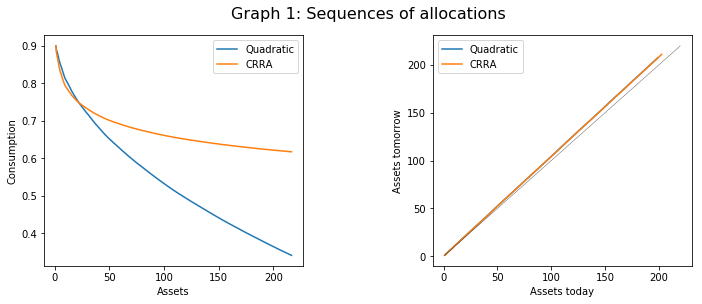

In [31]:
#Plot
plt.figure
plt.suptitle("Graph 1: Sequences of allocations", x=0.75, y=1, fontsize=16)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0, right=1.5, hspace=0.5, wspace=0.5)

plt.subplot(121)
plt.plot(assets,c1, label='Quadratic')
plt.plot(assets,c2, label='CRRA')
plt.xlabel('Assets')
plt.ylabel('Consumption')
plt.legend()

plt.subplot(122)
plt.plot(assets[0:98], assets[1:99], label='Quadratic')
plt.plot(assets2[0:98], assets2[1:99], label='CRRA')
plt.plot(assets2,assets2, 'k', linewidth=0.3)
plt.xlabel('Assets today')
plt.ylabel('Assets tomorrow')
plt.legend()

In this young economy (meaning out of the steady state), the RA keeps accumulating assets, the more the richer she is. Note that the right hand side graph is not strictly speaking a policy function, but just the actual correlation between assets today and tomorrow. 

Indeed, $\rho$ > $r$, we are out of the steady state. The consumption exhibits a declining profile, since agent's impatience is higher than the technologic rate to move value to future (i.e., the rate of return). We can confirm this insight by taking a look at the **consumption temporal profile**.

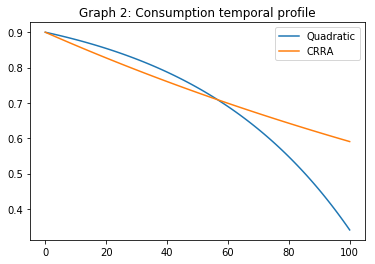

In [18]:
#Consumption temporal profile
time=np.linspace(0,100,100)
plt.plot(time, c1, label='Quadratic')
plt.plot(time,c2, label='CRRA')
plt.title('Graph 2: Consumption temporal profile')
plt.legend()

**1.2. Uncertainty**

With uncertainty, the relevant EE is (4) (instead of 4.1). Now, we will simulate this economy only for the **Quadratic utility**. 

In [33]:
#Sequence of allocations
pi = np.array([[(1+gamma)/2, (1-gamma)/2],[(1-gamma)/2, (1+gamma)/2]])
assets = np.ones((period))
for t in range(2,period-2):
    if y[t]==Y[0]:
        assets[t+2]=((y[t] + (1+r)*assets[t] - assets[t+1] - cbar)/((1+r)*beta) - pi[0,0]*(Y[0]+((1+r)*assets[t+1])-cbar) - pi[0,1]*(Y[1]+((1+r)*assets[t+1])-cbar))/(-pi[0,0] - pi[0,1])
    else:
        assets[t+2]=((y[t] + (1+r)*assets[t] - assets[t+1] - cbar)/((1+r)*beta) - pi[1,0]*(Y[0]+((1+r)*assets[t+1])-cbar) - pi[1,1]*(Y[1]+((1+r)*assets[t+1])-cbar))/(-pi[0,0] - pi[0,1])

c= np.ones((period)) 
for t in range(2,period-1):
    c[t]=y[t] + (1+r)*assets[t] - assets[t+1] 

#Check borrowing constraint
bind0=np.min(assets)-a_min
bind1=np.min(assets)-a_min0
print('Slack (Quadratric + Natural Borrowing limit):'"{0:.2f}".format(bind0))
print('Slack (Quadratric + No debt):'"{0:.2f}".format(bind1))

Slack (Quadratric + Natural Borrowing limit):23.50
Slack (Quadratric + No debt):1.00


As before, the borrowing constraint does not bind no matter how strict was the liquidity limit. 

Text(0,0.5,'Assets tomorrow')

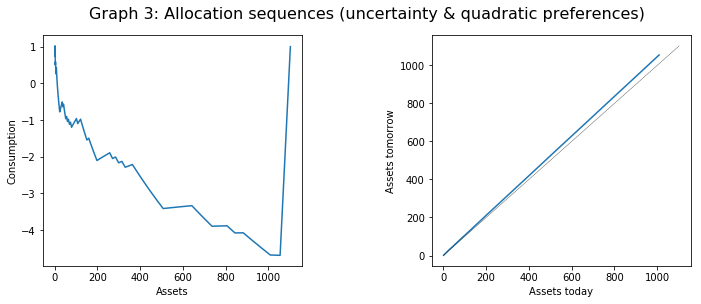

In [35]:
#Plot
plt.figure
plt.suptitle("Graph 3: Allocation sequences (uncertainty & quadratic preferences)", x=0.75, y=1, fontsize=16)
plt.subplots_adjust(top=0.9, bottom=0.1, left=0, right=1.5, hspace=0.5, wspace=0.5)


plt.subplot(121)
plt.plot(assets,c, label='Quadratic')
#plt.plot(assets,c2, label='CRRA')
plt.xlabel('Assets')
plt.ylabel('Consumption')
#plt.legend()

plt.subplot(122)
plt.plot(assets[0:98], assets[1:99], label='Quadratic')
#plt.plot(assets2[0:98], assets2[1:99], label='CRRA')
plt.plot(assets,assets, 'k', linewidth=0.3)
plt.xlabel('Assets today')
plt.ylabel('Assets tomorrow')
#plt.legend()

Same result as before: declining consumption profile, and increasing accumulation of assets. Notice that consumption also declines with the level of assets (which basically is a consequence of the consumption-savings trade-off: the less you consume the more assets you own). 